In [48]:
using PowerModelsDistribution
using Plots, SCIP, Alpine
using Ipopt
using JuMP
using NBInclude
@nbinclude("add_generators_to_load_buses.ipynb")
@nbinclude("plot_network.ipynb")
@nbinclude("power_network.ipynb")


silence!()
;

In [49]:
V_min = 0.95
V_max = 1.05
P_max = 15.0        # a cap over PV capacity
Q_max = P_max
pf = 0.95

η = sqrt(1/pf^2-1)
ν = 0.95

pn = power_network("feeder 5")
eng = pn.eng

add_generators_to_load_buses!(eng, -P_max, P_max, -Q_max, Q_max)

data_math = transform_data_model(eng)
load_profiles = pn.load_profiles_rep
pv_profile = pn.pv_profile_rep
;

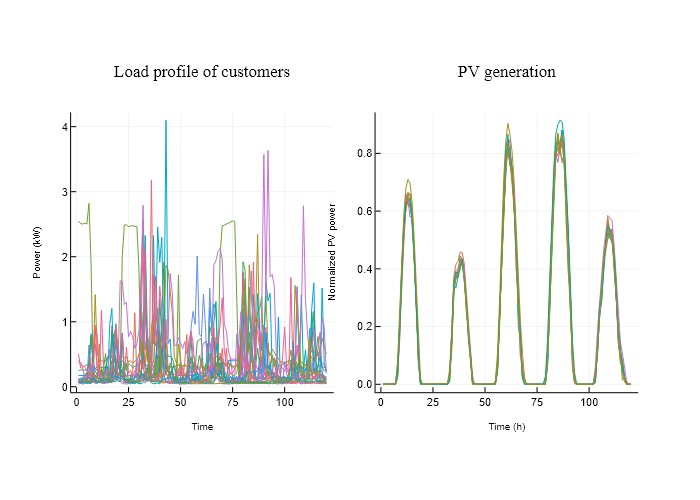

In [50]:
T, L = size(load_profiles) # T: number of time steps, N: number of load points
Ω = 1:size(pv_profile, 2)
S = T * length(Ω)
Δt = 24 / T * length(pn.rep_days)

# Predefine the layout
plt = plot(layout=(1, 2), size=(1200, 300), legend=false,
      titlefont="Times", margin=6 * Plots.mm,
      ylabelfontsize=7, xlabelfontsize=7, titlefontsize=12)

# Plot the first subplot using plot_load_profiles!
plot_load_profiles!(pn, subplot=1)

# Plot the second subplot
for s in Ω
      plot!(subplot=2, collect(pv_profile[:, s]),
            title="PV generation", xlabel="Time (h)", ylabel="Normalized PV power")
end

display(plt)

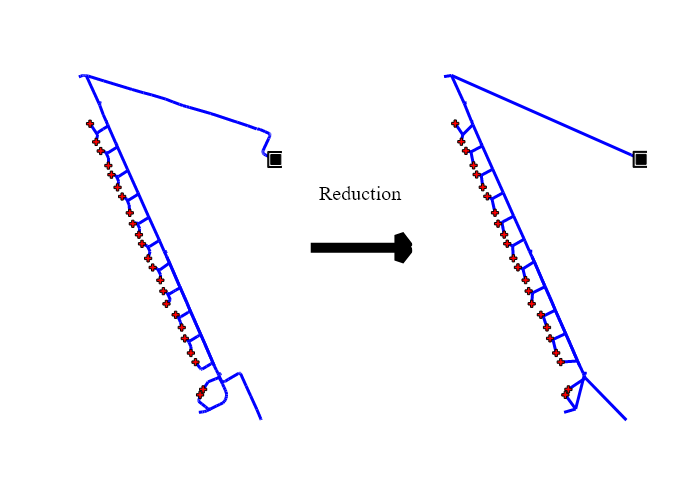

In [51]:
plot_reduced_and_original(pn)

In [52]:
# Define time_series for each load
time_series_data = Dict{String, Any}()
LP_repeated = repeat(load_profiles, length(Ω))
LP_repeated = DataFrame(LP_repeated, :auto)
pv_vector = pv_profile[:]

for (i, load_profile) in enumerate(eachcol(LP_repeated))
    ts_name = "load_$(i)_series"  # Unique time_series name
    time_series_data[ts_name] = Dict(
        "time" => collect(1:S),           # Time steps (1 to T)
        "values" => load_profile,        # The load profile for this load
        "offset" => 0.0,                 # Start time offset (default = 0.0 hours)
        "replace" => true                # Replace load value instead of scaling
    )
end

# Add the time_series dictionary to the top-level of data_math
data_math["time_series"] = time_series_data

# Define the total number of time steps
data_math["time_series"]["num_steps"] = S  # Total number of time slots (e.g., 96 for 15-min intervals)

# Create the multi-network
multi_network = make_multinetwork(data_math; time_elapsed=Δt)  # Δt is the time step in hours
;

In [53]:
# adjust loads in the multi-network
for t in 1:S
    for load_id in keys(multi_network["nw"]["$t"]["load"])
        # Set the active power ("pd") for this load at time step `t`
        #qp_ratio = multi_network["nw"]["$t"]["load"][load_id]["qd"]/multi_network["nw"]["$t"]["load"][load_id]["pd"]
        
        multi_network["nw"]["$t"]["load"][load_id]["pd"] *= LP_repeated[t, parse(Int, load_id)]
        multi_network["nw"]["$t"]["load"][load_id]["qd"] *= LP_repeated[t, parse(Int, load_id)]
    end
end
S_base = multi_network["nw"]["1"]["settings"]["sbase"]
;

In [55]:
##############################################################################################
######################################################     NETWORK, SETS, and PARAMETERS
##############################################################################################
days = 1:length(pn.rep_days)
Time = 1:T/length(pn.rep_days)
wght = pn.rep_days_w 

pm = instantiate_mc_model(multi_network, SOCConicUBFPowerModel, build_mn_mc_opf, multinetwork=true)   #ACPUPowerModel **LPUBFDiagPowerModel**************************

gen_keys = filter( gen_id -> startswith(ref(pm, 1, :gen, gen_id)["name"], "gen_"), keys(ref(pm, 1, :gen)) )
bus_keys = keys(ref(pm, 1, :bus))
# Initialize the lookup dictionary
g2l = Dict{Int, Int}()

# Extract all generator and load indices for the network
load_keys = keys(ref(pm, 1, :load))
ds_indices_tupple = [(l, d, s, n) for l in load_keys, d in days, s in Ω, n in 1:S if 
                 ((d-1)*length(Time) + (s-1)*length(Ω)*length(days) + 1 <= n &&
                  n <= (d-1)*length(Time) + (s-1)*length(Ω)*length(days) + 24)]

# Create a mapping
for gen_id in gen_keys
    gen_bus = ref(pm, 1, :gen, gen_id)["gen_bus"]
    for load_id in load_keys
        load_bus = ref(pm, 1, :load, load_id)["load_bus"]
        if gen_bus == load_bus
            g2l[gen_id] = load_id
            break
        end
    end
end

load_bus = [ref(pm, 1, :load)[l]["load_bus"] for l in keys(ref(pm, 1, :load))]
load_node = Dict(l => (ref(pm, 1, :load)[l]["load_bus"] , ref(pm, 1, :load)[l]["connections"][1]) for l in keys(ref(pm, 1, :load)))
;

In [56]:
##############################################################################################
######################################################          VARIABLES
##############################################################################################
@variable(pm.model, OB)

# Add flexibility variables to the model
@variable(pm.model, P_max/S_base >= Pg[l=gen_keys] >= 0)  # Positive flexibility per load and time

@variable(pm.model, ω >=0)
# Add auxiliary variable for voltage magnitude deviation
@variable(pm.model, τ[d in days, s in Ω] >=0)

##############################################################################################
######################################################          OBJECTIVES
##############################################################################################
@objective(pm.model, Max, OB)
@constraint(pm.model, OB <= sum(Pg))
          
##############################################################################################
######################################################          CONSTRAINTS
##############################################################################################
@constraint(pm.model, cal_p[n in keys(nws(pm)), l in gen_keys], 
    PowerModelsDistribution.var(pm, n, :pg, l)[ref(pm, n, :gen, l, "connections")] .== Pg[l]*pv_vector[n])
@constraint(pm.model, cal_q[n in keys(nws(pm)), l in gen_keys], 
    PowerModelsDistribution.var(pm, n, :qg, l)[ref(pm, n, :gen, l, "connections")] .== 0)

@constraint(pm.model, ω + sum(τ[d, s]*wght[d] for d in days for s in Ω)/(length(Ω)*length(days)*(1-ν)) ≤ V_max^2) # modify for AC OPF********************

@constraint(pm.model, [(l, d, s, n) in ds_indices_tupple],
    PowerModelsDistribution.var(pm, n, :w)[load_node[l][1]][load_node[l][2]] - ω ≤ τ[d, s]) # modify for AC OPF *****************************************
;

In [ ]:
ipopt = optimizer_with_attributes(Ipopt.Optimizer, "tol" => 1e-6, "print_level" => 0)
using MosekTools
set_optimizer(pm.model, Mosek.Optimizer)

                               
# Solve the optimization problem
optimize!(pm.model)
;

Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4218002         
  Affine conic cons.     : 2301600 (9295200 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 5786475         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 122423
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 17.09           
Lin. dep.  - primal attempts        : 1                 su

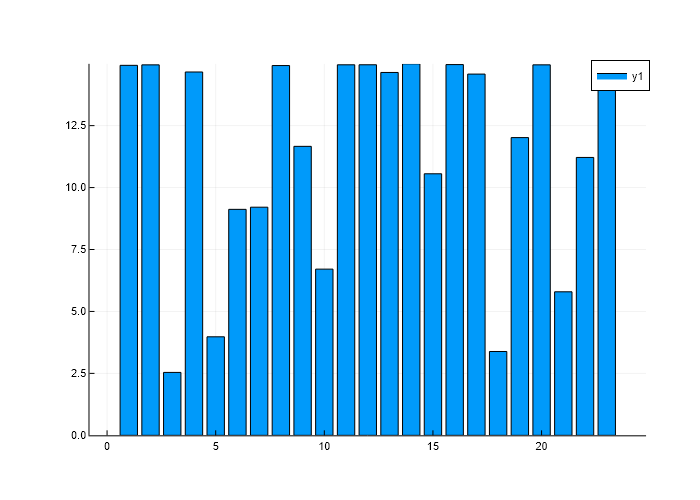

In [42]:
plotlyjs()
bar(JuMP.value.(Pg).data.*S_base)

In [47]:
using Statistics
mean(JuMP.value.(Pg).data.*S_base)

11.489541906250096